In [1]:
'''
Cumulative test of RouteMap, BusModel, and TripDynamics.
'''

'\nCumulative test of RouteMap, BusModel, and TripDynamics.\n'

In [2]:
# General Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Package Imports
import RouteMap as rm
import BusModel as bm
import TripDynamics as td
import Helper_Methods as hm

In [4]:
# Import the relevant area data:
# All Transit Stops:
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

# All signal lights:
signals_path = "./Data/Signals/Traffic_Signals.shp"
signals = gpd.read_file(signals_path)

# All Streets:
seattle_streets_data = "./Data/Seattle_Streets/Seattle_Streets.shp"
seattle_streets = gpd.read_file(seattle_streets_data)

In [5]:
# make a duplicate of the stops
all_stops = stops.copy()

# make a series of the signal geometry
all_signals = signals['geometry'].reset_index(drop=True)

# get the speed limits of all streets in the dataset
limits = seattle_streets[['geometry', 'SPEEDLIMIT']]

In [6]:
# set the route number, number of samples of points
# and time period of interest
route = 22
concat_val = 6
period = 'AM'

# Import the route data
route_path = "./Data/Routes/rt{}_pts.shp".format(route)
route_raw = gpd.read_file(route_path)

# filter to the resolution of the concat value
route_concat = route_raw[::concat_val]
route_concat = route_concat.reset_index(drop=True)

# get a series of the geometry and elevation from the data
route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']

# using the helper method get_stops, find all stops the route intersects with.
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)

In [9]:
# Generate a RouteMap with the RouteMap module, passing 
# the route geometry, elevation, limits, route_stops, 
# signals.
route_test_map = rm.RouteMap(route_geometry,
                             route_elevation,
                             limits,
                             route_stops,
                             all_signals,
                             debug = True)

#save the route_map as a csv for future, faster, use. 
route_test_map.get_gdf().to_csv('route_map_{}.csv'.format(route))

DEBUGGER ACTIVE
speeds assignedmainnnn
stops assigned
signals assigned


In [7]:
# Load the RouteMap from the CSV
# First, generate a routemap from the geometry and elevation
route_test_map = rm.RouteMap(route_geometry, route_elevation)

# Add in the details from the saved CSV
route_test_map = route_test_map.load_from_gdf('route_map_{}.csv'.format(route))

In [8]:
# Use in-built methods in RouteMap to get a smoothed elevation
# as a pandas series
smoothed_test_elevation = route_test_map.smooth_elevation()

# set the smoothed elevation as the route_test_map's elevation
smoothed_test_map = route_test_map.set_elevation(smoothed_test_elevation)


<Axes: >

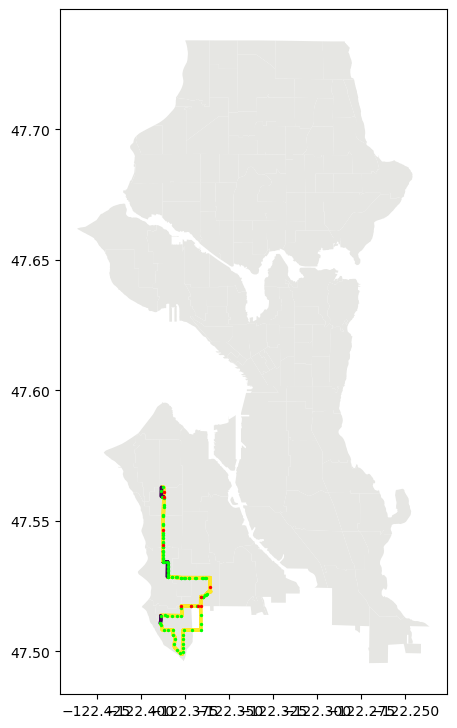

In [27]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

# get the geodtaframe of the route_map
smooth_route_gdf = smoothed_test_map.get_gdf()

# plot the route by speed limit individually
smooth_route_gdf.plot(column='speed_limit[km/s]',
                      markersize=2,
                      ax=ax,
                      alpha=1,
                      zorder=10)

# plot the stops and signals
smooth_route_gdf[smooth_route_gdf['is_stop'] == True].plot(color='lime',
                                                           markersize=2,
                                                           ax=ax,
                                                           zorder=15)
smooth_route_gdf[smooth_route_gdf['is_signal'] == True].plot(color='red',
                                                             markersize=2,
                                                             ax=ax,
                                                             zorder=20)

In [29]:
# Creating a bus model:
# Import an acceleration profile
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()

# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

# Create a default bus with the acceleration profile from above,
# otherwise using the default parameters
default_bus = bm.BusModel(a_prof)

In [33]:
# Creating a trip:
# Load the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

# filter the ridership to the selected period and route
trip_ridership = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]

# sort the route_ridership so the stops are in proper order
sorted_riders = trip_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
sorted_riders = sorted_riders.reset_index(drop = True)
sorted_riders['Index'] = sorted_riders.index

# get the mean ridership change at each stop
sorted_riders_diff = sorted_riders['AveOn'] - sorted_riders['AveOff']

# generate a tripDynamics object, using the route map, bus, and ridership
# changes
test_trip_dynamic = td.TripDynamics(smoothed_test_map,
                                    default_bus,
                                    sorted_riders_diff)

# Run the trip
test_trip = test_trip_dynamic.bus_trip()

mean load: -4.662354528905931
    stdev: 52.98995014986057


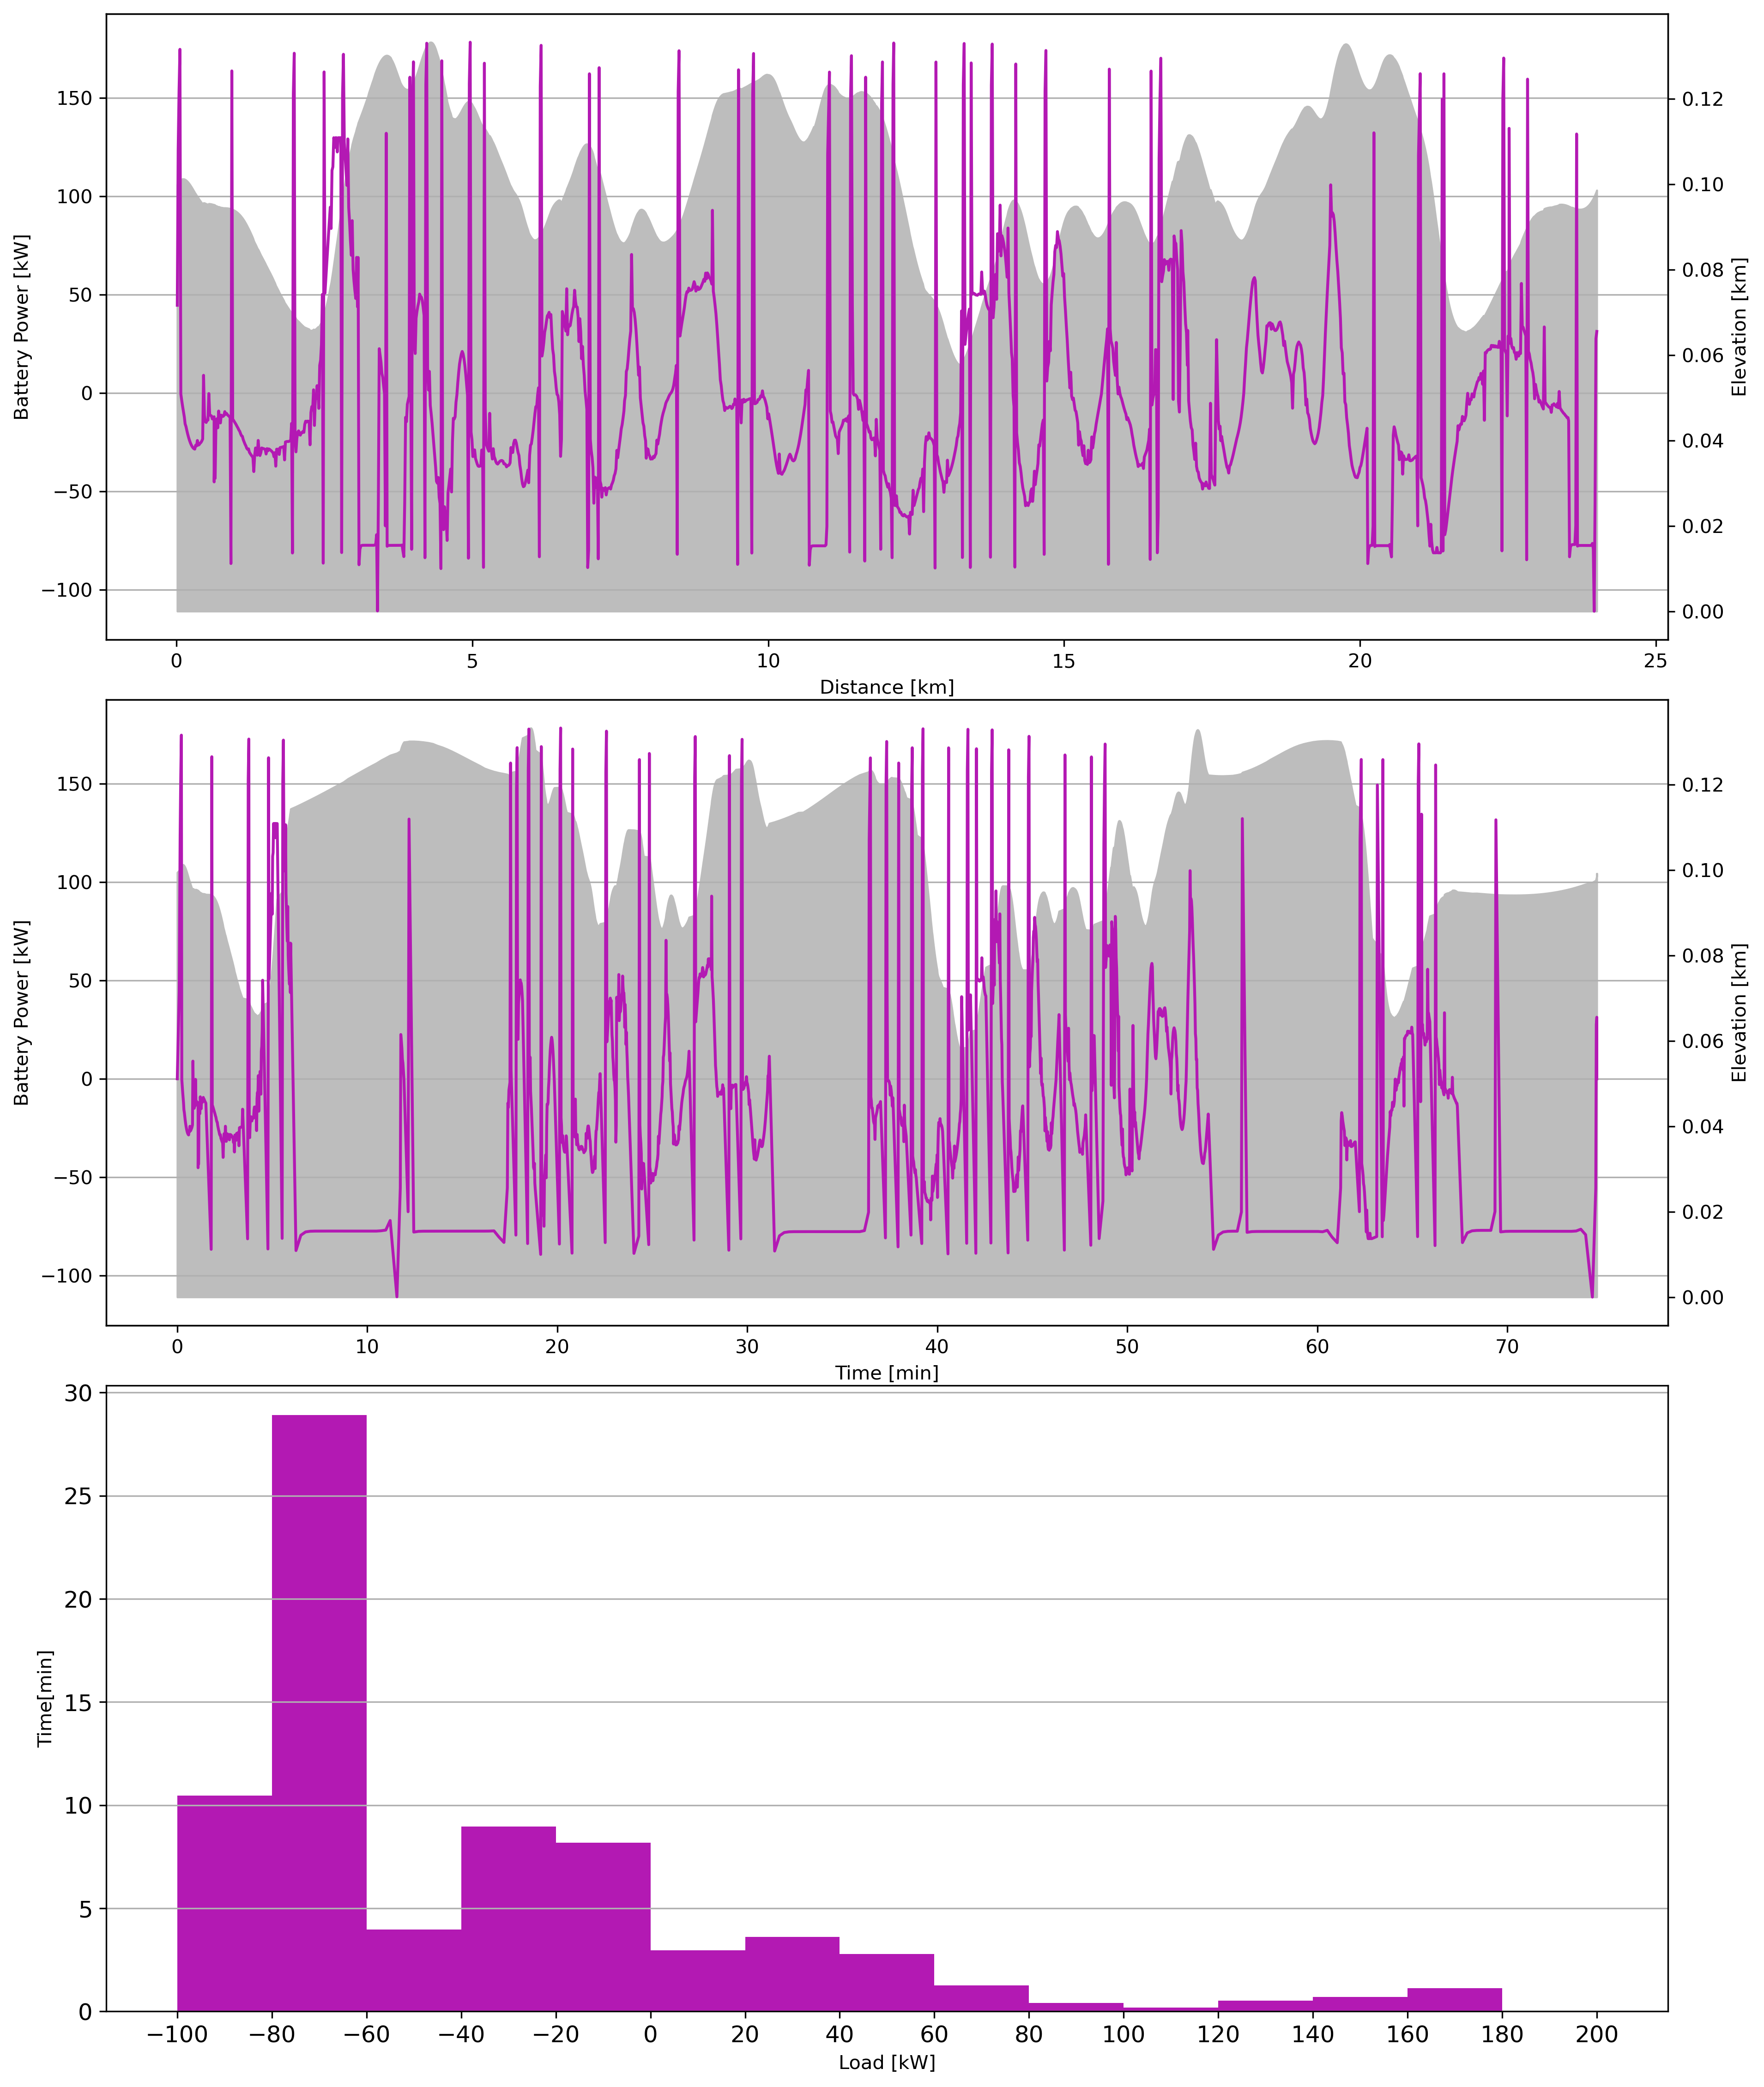

In [112]:
# plot the ESS load:
# get the ESS profile of the trip:
ess_prof = test_trip_dynamic.generate_ESS_profile()

# Convert the ess profile to kilowatts:
ess_prof = ess_prof/1000

raw_prof = test_trip['power_needed[W]']/1000

# get the distance series:
distance = test_trip['cumulative_distance[km]']

# get the elevation series:
elev = test_trip['elevation[km]']

# get the time change series:
delta_tees = test_trip['time_change[s]']

# get running time series
time = test_trip['elapsed_time[s]']

# convert time change to minutes
delta_tees = delta_tees/60
time = time/60

# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()

# Load profile (distance based)
ax[0].plot(distance, ess_prof, c='#b319b3')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("Battery Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')

# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

# Load profile (time based)
ax[1].plot(time, ess_prof, c='#b319b3')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("Battery Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
ax[2].hist(ess_prof, color='#b319b3', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

print('mean load: {}'.format(ess_prof.mean()))
print('    stdev: {}'.format(ess_prof.std()))

mean load: -25.11345404115572
    stdev: 67.4547414776278


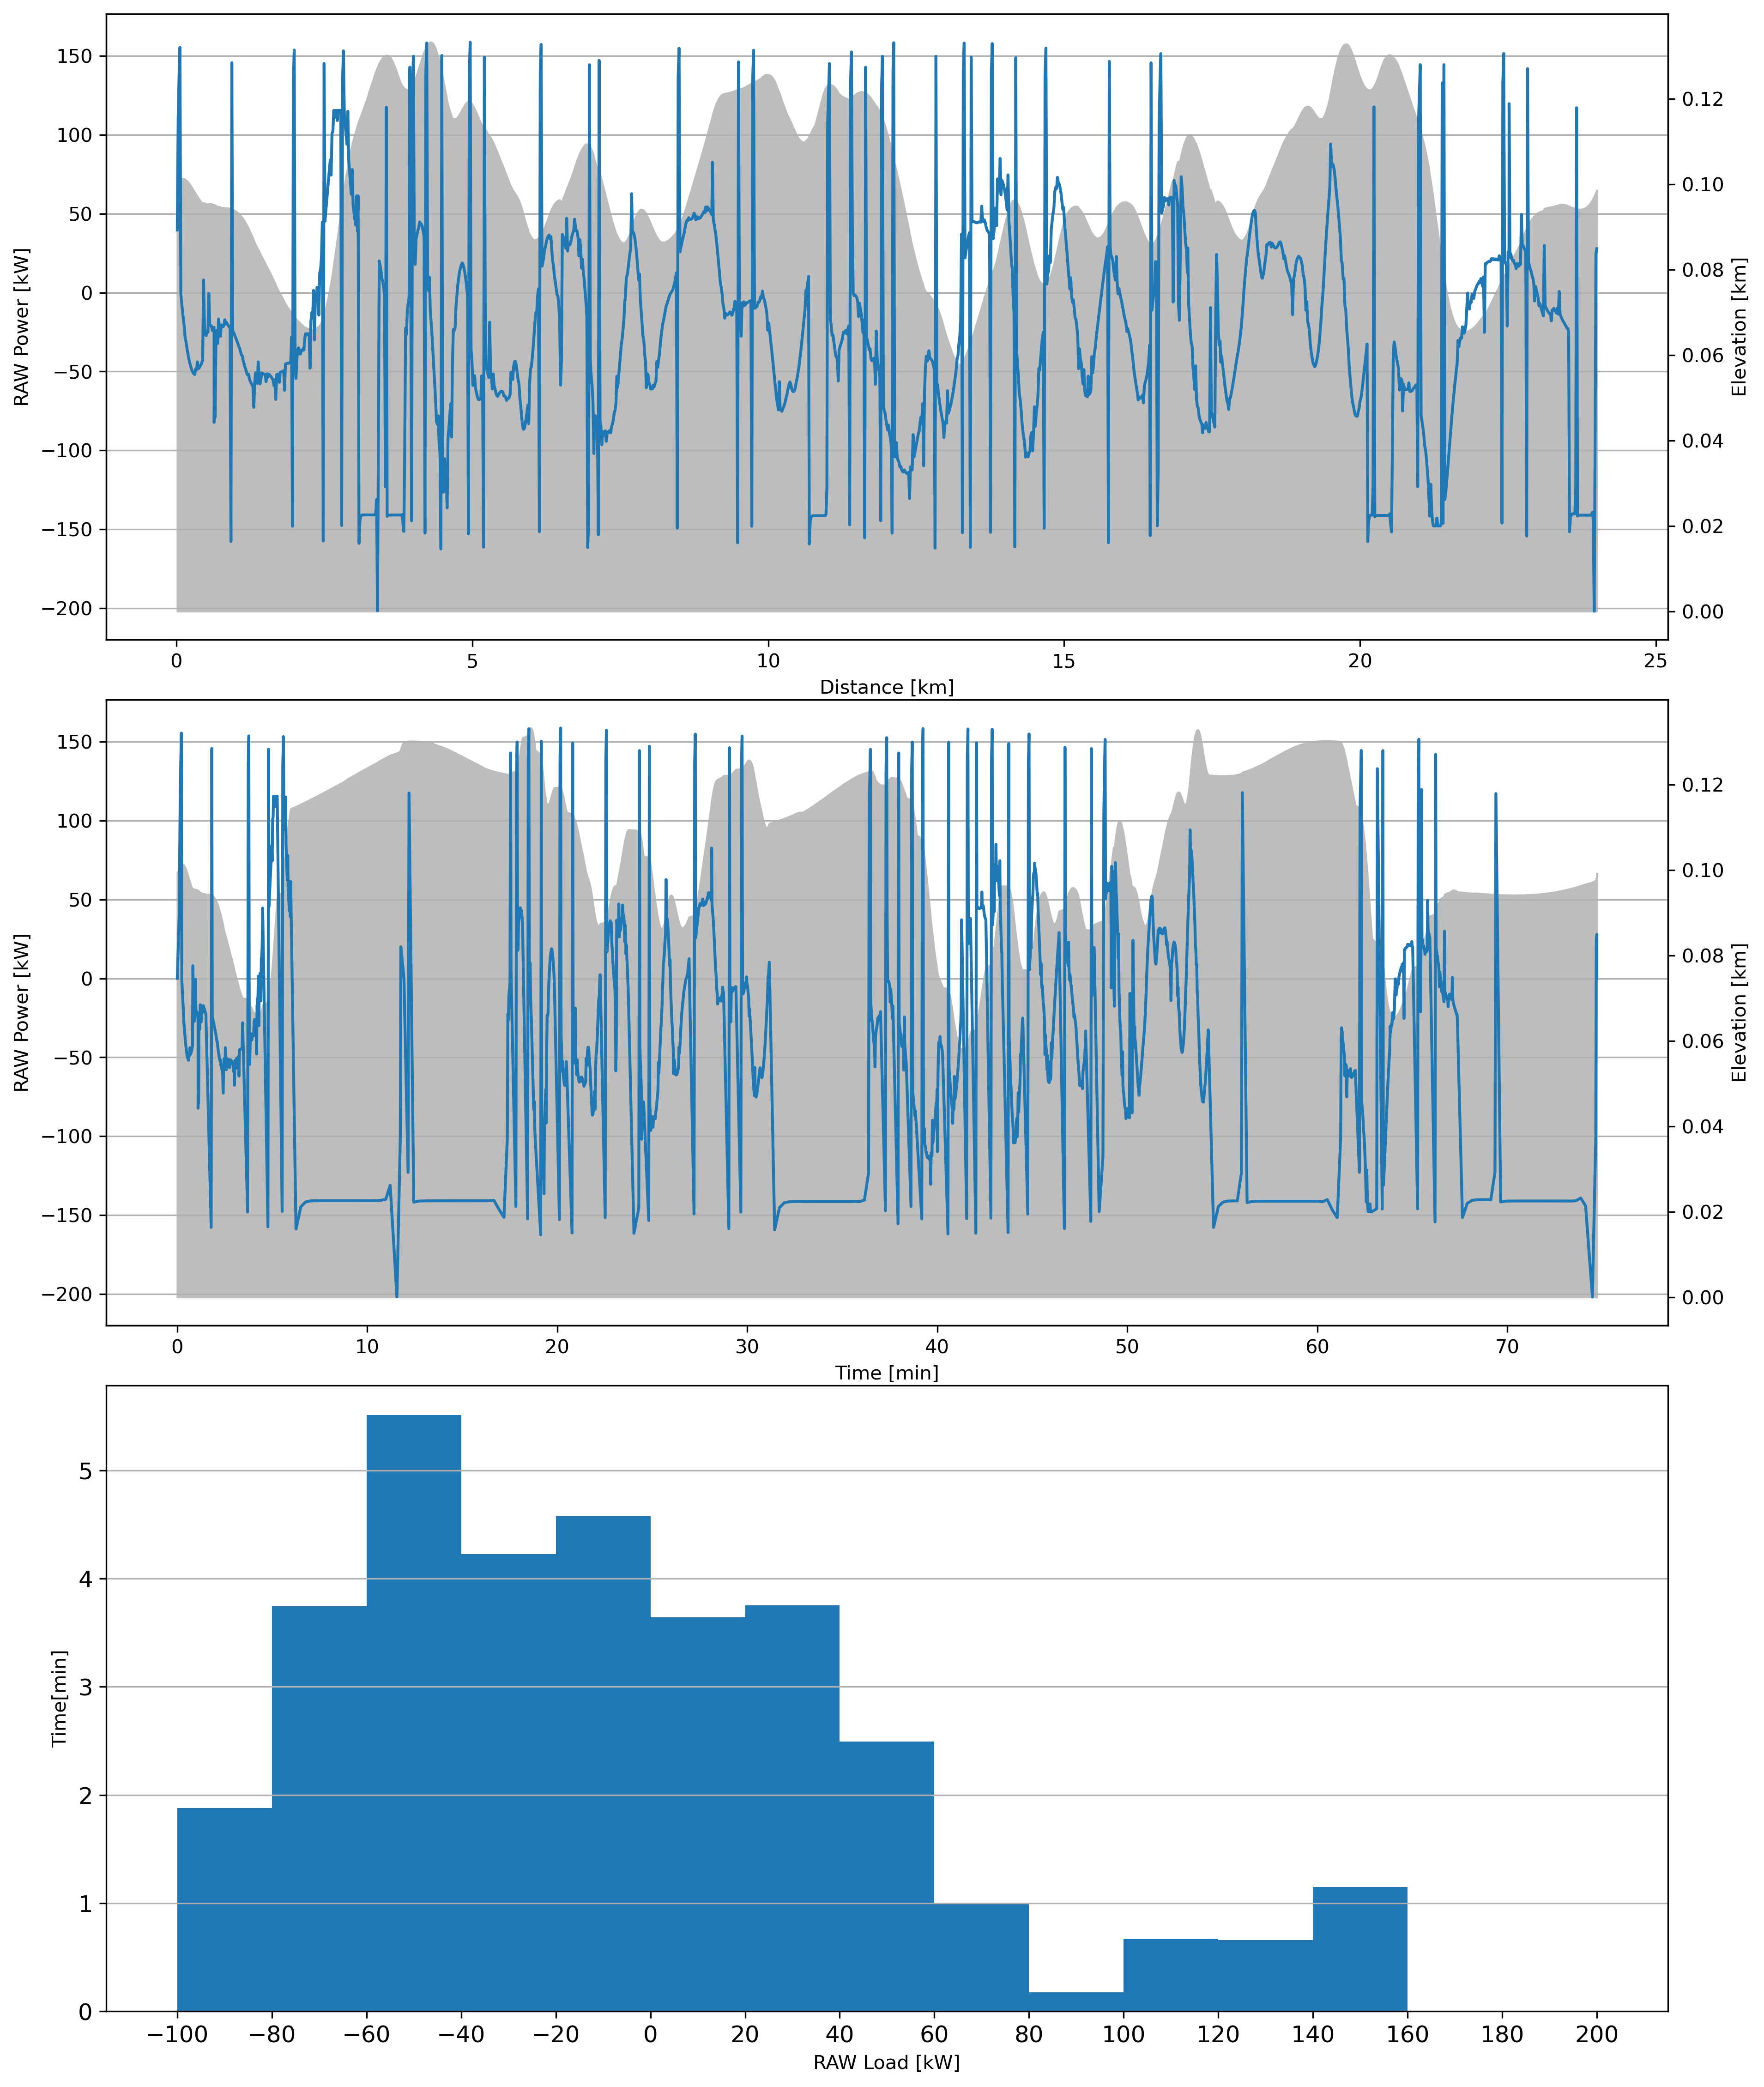

In [114]:
# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()

# Load profile (distance based)
ax[0].plot(distance, raw_prof, c='tab:blue')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("RAW Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')

# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

# Load profile (time based)
ax[1].plot(time, raw_prof, c='tab:blue')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("RAW Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
ax[2].hist(raw_prof, color='tab:blue', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('RAW Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

print('mean load: {}'.format(raw_prof.mean()))
print('    stdev: {}'.format(raw_prof.std()))

In [95]:
test_trip['ess']=ess_prof

braking = test_trip[test_trip['st'] == 'Stopping_brake']['time_change[s]']
accelerating = test_trip[(test_trip['st'] == 'speed_lim_accel') | (test_trip['st'] == 'accel_from_0')]['time_change[s]']
maintaining = test_trip[test_trip['st'] == 'maintain_v']['time_change[s]']

print('mean and cumulative time spent:')
print('Accelerating:   Braking:    Maintaining:  ')
print(accelerating.mean(), braking.mean(), maintaining.mean())
print(accelerating.sum(), braking.sum(), maintaining.sum())


p_braking = test_trip[test_trip['st'] == 'Stopping_brake']['ess']
p_accelerating = test_trip[(test_trip['st'] == 'speed_lim_accel') | (test_trip['st'] == 'accel_from_0')]['ess']
p_maintaining = test_trip[test_trip['st'] == 'maintain_v']['ess']

print()
print('mean and std power spent:')
print('Accelerating:   Braking:    Maintaining:  ')
print(p_accelerating.mean(), p_braking.mean(), p_maintaining.mean())
print(p_accelerating.std(), p_braking.std(), p_maintaining.std())

mean and cumulative time spent:
Accelerating:   Braking:    Maintaining:  
2.11373234293651 15.575514919507057 1.4028783052793363
133.165137605 545.143022182747 1959.8209924752318

mean and cumulative power spent:
Accelerating:   Braking:    Maintaining:  
156.63835089341768 -81.08455791438764 -3.572924707421691
20.746489728584447 7.25743097016867 37.910224201877675


In [100]:
print((accelerating.sum()*p_accelerating.mean() + 
      braking.sum()*p_braking.mean() + 
      maintaining.sum()*p_maintaining.mean()) / (accelerating.sum() +braking.sum() + maintaining.sum()) / 1000)

-0.01150292669445944
